In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
import statsmodels.api as sm
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.transforms as transforms
import quandl
from tqdm import tqdm
import dask
import dask.dataframe as dd


## Step 1: Data Loading and Manipulation

1a. Reading in the data slices and merge them into one dataframe

In [575]:
# List of file names
file_names = [f"output_{i}.xls" for i in range(3, 10)]

# Load the dataframes into a list using list comprehension
dfs = [pd.read_excel(file_name) for file_name in file_names]

# Sequentially merge the dataframes
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = pd.merge(df_merged, df)


df_10 = pd.read_excel('output_10.xls')
df_merged_final = pd.merge(df_merged,df_10, how = 'left')
df_merged_final


,Unnamed: 0,430017.BJ,430017.BJ.1,430017.BJ.2,430017.BJ.3,430017.BJ.4,430017.BJ.5,430017.BJ.6,430047.BJ,430047.BJ.1,...,873576.BJ.4,873576.BJ.5,873576.BJ.6,873593.BJ,873593.BJ.1,873593.BJ.2,873593.BJ.3,873593.BJ.4,873593.BJ.5,873593.BJ.6
0,NaN,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,诺思兰德,诺思兰德,...,天力复合,天力复合,天力复合,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技
1,NaN,开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元),开盘价(元),收盘价(元),...,PB市净率,PCF市现率,总市值(元),开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元)
2,2021/09/03,--,--,--,--,--,--,--,11.72,10.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/09/06,--,--,--,--,--,--,--,11.13,11.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/09/07,--,--,--,--,--,--,--,11.8,10.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [576]:
# export the data for record keeping
#df_merged_final.to_csv("merged.csv")

1b. Cleaning the data, dropping NAs and unneccessary data comments

In [577]:
# change the name of the first column to 'Date'
df_renamed=df_merged_final.rename(columns = {'Unnamed: 0':'Date'})
# drop the last three rows of the dataframe
df_dropped = df_renamed.iloc[:-3]
# remove excess rows
df_dropped_na = df_dropped.dropna(how='all')

# copy the data for further processing and include exisiting columns as new rows
df = df_dropped_na.copy()
df = pd.DataFrame(np.vstack([df.columns, df]))


1c: Set up the Final dataframe format

In [578]:

# Get meta information from the first 3 rows
stock_ids = df.iloc[0, 1:].to_list()
stock_names = df.iloc[1, 1:].to_list()
descriptors = df.iloc[2, 1:].to_list()

# Drop the meta rows
df = df.iloc[3:].reset_index(drop=True)

dfs = []  # To store dataframes for each stock

# Assuming every 7 columns pertain to one stock (from your example: Open, Close, etc.)
num_columns_per_stock = 7
total_columns = df.shape[1]

for i in range(1, total_columns, num_columns_per_stock):
    end_idx = min(i + num_columns_per_stock, total_columns)
    subset = df.iloc[:, [0] + list(range(i, end_idx))]
    
    # Rename columns for easier melting
    subset.columns = ["Date"] + descriptors[i-1:end_idx-1]
    
    # Melt and reshape
    melted = subset.melt(id_vars=["Date"], 
                         value_vars=descriptors[i-1:end_idx-1],
                         var_name="Descriptor",
                         value_name="Value")
    
    # Add stock information
    melted["stock_id"] = stock_ids[i-1]
    melted["stock_name"] = stock_names[i-1]
    
    dfs.append(melted)

# Combine the dfs
final_df = pd.concat(dfs, axis=0).reset_index(drop=True)

# Pivot to get descriptors as columns
final_df = final_df.pivot_table(index=["Date", "stock_id", "stock_name"], 
                                columns="Descriptor", 
                                values="Value").reset_index()




/Users/frankzhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


In [579]:
final_df

Descriptor,Date,stock_id,stock_name
0,2021/09/03,430017.BJ,星昊医药
1,2021/09/03,430047.BJ,诺思兰德
2,2021/09/03,430090.BJ,同辉信息
3,2021/09/03,430139.BJ,华岭股份
4,2021/09/03,430198.BJ,微创光电
...,...,...,...
97266,2023/08/01,873305.BJ,九菱科技
97267,2023/08/01,873339.BJ,恒太照明
97268,2023/08/01,873527.BJ,夜光明
97269,2023/08/01,873576.BJ,天力复合


1d. Preparing the dataframe for further data population

In [593]:
df = df_dropped_na.copy()
df = pd.DataFrame(np.vstack([df.columns, df]))

# create multi-level index for faster access
df.columns = [df.iloc[0], df.iloc[1], df.iloc[2]]
df = df.drop(df.index[0:3])

# Reset the index
df = df.reset_index(drop=True)

all_stock_ids = final_df['stock_id'].unique()
all_stock_name = final_df['stock_name'].unique()
all_dates = final_df['Date'].unique()

# create new columns in final_df (opening price, closing price, volume, MCAP, PE Ratio, PB Ratio, PCF Ratio)
final_df['开盘价(元)'] = np.nan
final_df['收盘价(元)'] = np.nan
final_df['成交量(股)'] = np.nan
final_df['PE市盈率'] = np.nan
final_df['PB市净率'] = np.nan
final_df['PCF市现率'] = np.nan
final_df['总市值(元)'] = np.nan

new_columns = pd.MultiIndex.from_tuples(zip(df.iloc[0], df.iloc[1]))
df.columns = new_columns
df = df.iloc[2:]  # Remove the first two rows



In [601]:
# how many unique stock_id in final_df
print('unique stock_id in final_df: ', len(final_df['stock_id'].unique()))

unique stock_id in final_df:  211


In [602]:
df

,Date,430017.BJ,430017.BJ.1,430017.BJ.2,430017.BJ.3,430017.BJ.4,430017.BJ.5,430017.BJ.6,430047.BJ,430047.BJ.1,...,873576.BJ.4,873576.BJ.5,873576.BJ.6,873593.BJ,873593.BJ.1,873593.BJ.2,873593.BJ.3,873593.BJ.4,873593.BJ.5,873593.BJ.6
0,NaN,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,星昊医药,诺思兰德,诺思兰德,...,天力复合,天力复合,天力复合,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技,鼎智科技
1,NaN,开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元),开盘价(元),收盘价(元),...,PB市净率,PCF市现率,总市值(元),开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元)
2,2021/09/03,--,--,--,--,--,--,--,11.72,10.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/09/06,--,--,--,--,--,--,--,11.13,11.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/09/07,--,--,--,--,--,--,--,11.8,10.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2023/07/26,10.08,10.08,211272,15.1587,1.1074,12.777,1235578176,11.9,11.74,...,5.7941,39.0585,1905670000,99.03,91.01,1240831,43.328,14.2777,34.1267,4370485769.39
459,2023/07/27,10.13,10.07,204077,15.1436,1.1063,12.7644,1234352404,11.86,11.7,...,5.716,38.5321,1879990000,90.02,89.02,1014139,42.3806,13.9655,33.3805,4274921911.78
460,2023/07/28,10.05,10.08,217009,15.1587,1.1074,12.777,1235578176,11.83,11.61,...,5.6933,38.3786,1872500000,89.75,87.3,827340,41.5618,13.6956,32.7355,4192324004.7
461,2023/07/31,10.12,10.09,806928,15.1737,1.1085,12.7897,1236803948,11.63,11.54,...,5.7193,38.554,1881060000,87.99,86,599720,40.9429,13.4917,32.248,4129895354


In [600]:
df = df_dropped_na.copy()
#df = pd.DataFrame(np.vstack([df.columns, df]))

# more cleaning and data manipulation
df.columns = [(col[0] if 'Date' in col[0] else col) for col in df.columns]

# set Date as an index so that we can extract data by date as well
#df.set_index('Date', inplace=True)

# finally test data extraction
desired_value = df.at['2021/09/03', ('430017.BJ', 'xxxx company', '开盘价(元)')]
desired_value

KeyError: ('430017.BJ', '星昊医药', '开盘价(元)')

In [ ]:
final_df # the dataframe to populate

Descriptor,Date,stock_id,stock_name,开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元)
0,2021/09/03,430017.BJ,星昊医药,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021/09/03,430047.BJ,诺思兰德,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/09/03,430090.BJ,同辉信息,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/09/03,430139.BJ,华岭股份,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/09/03,430198.BJ,微创光电,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
97266,2023/08/01,873305.BJ,九菱科技,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97267,2023/08/01,873339.BJ,恒太照明,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97268,2023/08/01,873527.BJ,夜光明,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97269,2023/08/01,873576.BJ,天力复合,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_df.loc[97270, 'stock_name'] # testing data access

'鼎智科技'

1e. Finally populate the dataframe into long format for analysis

In [ ]:
to_iter = final_df.columns[3:]
# for each row in the dataframe and each financial ratio, we retrieve the value from the df
for i in tqdm(range(len(final_df))): # tqdm is a progress bar
    # stockid is the stock_id corresponding to the row
    stockid = final_df.loc[i, 'stock_id']
    stockname = final_df.loc[i, 'stock_name']
    date = final_df.loc[i, 'Date']
    for var in to_iter:
        temp_stockid = stockid
        if var == '收盘价(元)':
                temp_stockid = stockid + '.1'
        if var == '成交量(股)':
                temp_stockid = stockid + '.2'
        if var == 'PE市盈率':
                temp_stockid = stockid + '.3'
        if var == 'PB市净率':
                temp_stockid = stockid + '.4'
        if var == 'PCF市现率':
                temp_stockid = stockid + '.5'
        if var == '总市值(元)':
                temp_stockid = stockid + '.6'
        desired_value = df.at[date, (temp_stockid, stockname, var)]
        final_df.loc[i, var] = desired_value
        

100%|██████████| 97271/97271 [14:09<00:00, 114.49it/s]


In [ ]:
#final_df.to_excel('cleaned_data.xlsx')

In [ ]:
final_df

Descriptor,Date,stock_id,stock_name,开盘价(元),收盘价(元),成交量(股),PE市盈率,PB市净率,PCF市现率,总市值(元)
0,2021/09/03,430017.BJ,星昊医药,--,--,--,--,--,--,--
1,2021/09/03,430047.BJ,诺思兰德,11.72,10.8,3632148,-109.5934,10.7975,-267.6517,2778302192.4
2,2021/09/03,430090.BJ,同辉信息,3.5,3.6,20551123,20.1111,2.1753,-20.3064,552000589.2
3,2021/09/03,430139.BJ,华岭股份,--,--,--,--,--,--,--
4,2021/09/03,430198.BJ,微创光电,11.49,10.4,2942570,21.475,2.6948,30.2515,1290910982.4
...,...,...,...,...,...,...,...,...,...,...
97266,2023/08/01,873305.BJ,九菱科技,10.72,11.21,960606,24.43,1.6216,12.6514,502420990
97267,2023/08/01,873339.BJ,恒太照明,4.22,4.19,240265,7.0055,1.5983,4.7065,922653922
97268,2023/08/01,873527.BJ,夜光明,6.82,6.78,30453,12.7104,1.0707,29.5237,407089506
97269,2023/08/01,873576.BJ,天力复合,18.18,21,5030057,30.705,6.8319,46.0543,2247000000


## Inclusion Criteria

The inclusion criteria is the market cap, at any given date the **top 30 stock in terms of MCap** will be included for the index.

In [ ]:
# Cleaning data
df_a = final_df.copy()

# only keep Date, stock_id, stock_name, 收盘价(元), 总市值(元)
df_a = df_a[['Date', 'stock_id', 'stock_name', '收盘价(元)', '总市值(元)']]

# drop rows with '--'
df_a = df_a[df_a['总市值(元)'] != '--']

# get rid of datetime where there is only one observation
df_a = df_a.groupby('Date').filter(lambda x: len(x) > 2)

# for each date in final_df, sort by MCAP
df_a_sorted = df_a.sort_values(by=['Date', '总市值(元)'], ascending=[True, False])

# limit each datetime to have at most 30 observations
df_a_sorted_30 = df_a_sorted.groupby('Date').head(30)
# only look at the first day of each month
#df['datetime'] = pd.to_datetime(df['datetime'])
#df = df[df['datetime'].dt.day == 1]
df_a_sorted_30.head()

# limit each datetime to have at most 50 observations
df_a_sorted_50 = df_a_sorted.groupby('Date').head(50)
df_a_sorted_50.head()

Descriptor,Date,stock_id,stock_name,收盘价(元),总市值(元)
107,2021/09/03,835185.BJ,贝特瑞,99.8,48441537770
111,2021/09/03,835368.BJ,连城数控,112,25833920000
118,2021/09/03,836077.BJ,吉林碳谷,30.34,9568492487.959999
122,2021/09/03,836239.BJ,长虹能源,99.16,8060034873.32
86,2021/09/03,833819.BJ,颖泰生物,6.22,7624476000


In [ ]:
df_weights = df_a_sorted_50
# set datetime as index
#df_weights = df_weights.set_index('datetime')
df_weights.head(40)

Descriptor,Date,stock_id,stock_name,收盘价(元),总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30
107,2021/09/03,835185.BJ,贝特瑞,99.8,48441537770,4.844154e+10,4.844154e+10,0.269687,0.269687
111,2021/09/03,835368.BJ,连城数控,112,25833920000,2.583392e+10,2.583392e+10,0.143824,0.143824
118,2021/09/03,836077.BJ,吉林碳谷,30.34,9568492487.959999,9.568492e+09,9.568492e+09,0.053270,0.053270
122,2021/09/03,836239.BJ,长虹能源,99.16,8060034873.32,8.060035e+09,8.060035e+09,0.044872,0.044872
86,2021/09/03,833819.BJ,颖泰生物,6.22,7624476000,7.624476e+09,7.624476e+09,0.042448,0.042448
169,2021/09/03,839729.BJ,永顺生物,17.77,4857429500,4.857430e+09,4.857430e+09,0.027043,0.027043
113,2021/09/03,835640.BJ,富士达,25.85,4852768800,4.852769e+09,4.852769e+09,0.027017,0.027017
98,2021/09/03,834599.BJ,同力股份,8.7,3936967500,3.936968e+09,3.936968e+09,0.021918,0.021918
47,2021/09/03,831961.BJ,创远信科,29.27,3217222528.66,3.217223e+09,3.217223e+09,0.017911,0.017911
146,2021/09/03,837344.BJ,三元基因,22.9,2789449000,2.789449e+09,2.789449e+09,0.015530,0.015530


## Exponential Moving Average Market Cap
 We choose the most common periods 15,30 in calculating our exponentially weighted moving average.

 $$
 EMA_{t,j} = (MCap_{t,j}*(\frac{Smoothing}{1+Periods}))+ EMA_{t-1,j}*(1-\frac{Smoothing}{1+Periods})
 $$

 Where we choose the common smoothing factor of 2. 

In [ ]:
# Exponential Moving Averages 15,30
ema_periods = [15, 30]
for period in ema_periods:
    ema_column = f"EMA_{period}"
    df_weights[ema_column] = df_weights.groupby("stock_id")["总市值(元)"].transform(lambda x: x.ewm(span=period).mean())


In [ ]:
# take a look at stock_name = 同心传动
df_weights[df_weights['stock_name'] == '同心传动'].head(5)

Descriptor,Date,stock_id,stock_name,收盘价(元),总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30
9361,2021/11/15,833454.BJ,同心传动,23.45,2376657500,2.376658e+09,2.376658e+09,0.009762,0.010010
9572,2021/11/16,833454.BJ,同心传动,20.38,2065513000,2.210714e+09,2.215900e+09,0.009114,0.009344
9783,2021/11/17,833454.BJ,同心传动,16.89,1711801500,2.021777e+09,2.036544e+09,0.008361,0.008601
9994,2021/11/18,833454.BJ,同心传动,16.83,1705720500,1.926307e+09,1.945390e+09,0.008008,0.008234
10205,2021/11/19,833454.BJ,同心传动,16.22,1643897000,1.853833e+09,1.876793e+09,0.007753,0.007966


## Weights

We calculate the weights for each stock based on their respective market cap at each date. Then, we compute the exponential moving averages (EMA) for the given periods (5, 12, 26, 50 days). The weight for each coin and each period is calculated as:

$$
w_{t, i} = \frac{EMA_{t, i}}{\sum_{j=1}^{n_t} EMA_{t, j}}
$$

where:
- $w_{t, i}$ represents the weight of stock $i$ at time $t$,
- $EMA_{t, i}$ is the market capitalization exponential moving average for stock $i$ at time $t$,
- $n_t$ is the top stocks at time $t$.

In [ ]:
# for each datetime, calculate the market cap/sum of market caps for each stock, call it weight
for dates in df_weights['Date'].unique():
    for period in ema_periods:
        ema_column = f"EMA_{period}"
        weight_column = f"weight_EMA{period}"
        
        # Calculate the weight based on the EMA column
        df_weights.loc[df_weights['Date'] == dates, weight_column] = (
            df_weights.loc[df_weights['Date'] == dates, ema_column] / 
            df_weights.loc[df_weights['Date'] == dates, ema_column].sum()
        )
df_weights

Descriptor,Date,stock_id,stock_name,收盘价(元),总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30
107,2021/09/03,835185.BJ,贝特瑞,99.8,48441537770,4.844154e+10,4.844154e+10,0.269687,0.269687
111,2021/09/03,835368.BJ,连城数控,112,25833920000,2.583392e+10,2.583392e+10,0.143824,0.143824
118,2021/09/03,836077.BJ,吉林碳谷,30.34,9568492487.959999,9.568492e+09,9.568492e+09,0.053270,0.053270
122,2021/09/03,836239.BJ,长虹能源,99.16,8060034873.32,8.060035e+09,8.060035e+09,0.044872,0.044872
86,2021/09/03,833819.BJ,颖泰生物,6.22,7624476000,7.624476e+09,7.624476e+09,0.042448,0.042448
...,...,...,...,...,...,...,...,...,...
97060,2023/08/01,430017.BJ,星昊医药,10.1,1238029720,1.235035e+09,1.238689e+09,0.007430,0.007383
97201,2023/08/01,837006.BJ,晟楠科技,13.16,1188179552,1.228059e+09,1.227827e+09,0.007388,0.007318
97198,2023/08/01,836892.BJ,广咨国际,8.9,1148581098.4,1.184357e+09,1.154470e+09,0.007125,0.006881
97071,2023/08/01,430510.BJ,丰光精密,8.61,1132915664.58,1.143295e+09,1.158309e+09,0.006878,0.006904


## Portfolio

To calculate the BJ index value at each datetime, we use a market capitalization-weighted methodology. The index value is calculated by summing the product of the price and weight for each stock at a specific datetime, and then normalizing the index value so that it starts at 100.

The formula for calculating the index value at time $t$ is:

$$
V_t = \frac{\sum_{i=1}^{n_t} (p_{t, i} \cdot  w_{t, i})}{V_0} \cdot  100
$$

where:
- $V_t$ represents the index value at time $t$,
- $p_{t, i}$ is the price of stock $i$ at time $t$,
- $w_{t, i}$ is the weight of stock $i$ at time $t$, calculated based on market capitalization,
- $V_0$ is the initial index value at the first datetime,
- $n_t$ is the total number of top stocks considered at time t.


In [ ]:
df_index = df_weights.copy()

# Initialize index_value columns for each period
for period in ema_periods:
    df_index[f'Allocation_EMA{period}'] = 0

### Root level balance

In [ ]:
# initialize the root-level index value
B_t0 = 100
# Allocation = B_t0 * weight when the date is the first date in the dataset
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Allocation_EMA15'] = (
    B_t0 * df_index.loc[df_index['Date'] == df_index['Date'].min(), 'weight_EMA15']
)
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Allocation_EMA30'] = (
    B_t0 * df_index.loc[df_index['Date'] == df_index['Date'].min(), 'weight_EMA30']
)

# Holdings = allocation/price when the date is the first date in the dataset
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Holdings_EMA15'] = (
    df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Allocation_EMA15'] /
    df_index.loc[df_index['Date'] == df_index['Date'].min(), '收盘价(元)']
)
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Holdings_EMA30'] = (
    df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Allocation_EMA30'] /
    df_index.loc[df_index['Date'] == df_index['Date'].min(), '收盘价(元)']
)

# balance is the sum of holdings * price at the first date use groupby
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Balance_EMA15'] = (
    df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Holdings_EMA15'] *
    df_index.loc[df_index['Date'] == df_index['Date'].min(), '收盘价(元)']
).sum()
df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Balance_EMA30'] = (
    df_index.loc[df_index['Date'] == df_index['Date'].min(), 'Holdings_EMA30'] *
    df_index.loc[df_index['Date'] == df_index['Date'].min(), '收盘价(元)']
).sum()

### Rebalance frequency

In [8]:
# find rebalance date (every 30 days)
def find_rebalance_date(df, period):
    rebalance_dates = df['Date'].unique()
    return rebalance_dates[period-1::period]

# rebalance every 7 days
rebalance_dates = find_rebalance_date(df_index, 7)
rebalance_dates
# insert the first date into the rebalance dates at the first position
rebalance_dates = np.insert(rebalance_dates, 0, df_index['Date'].min())
rebalance_dates

NameError: name 'df_index' is not defined

In [ ]:
#df_index.to_csv('df_index.csv')

### stocks, weights, and price alignment

Between rebalance dates, the stock_name and weights are not changed, only price is updated every period.

In [ ]:
# some initial cleaning and rename columns
df_index=df_index.rename(columns = {'Date':'datetime', '收盘价(元)':'price'})
df_og = final_df.copy()
df_og = df_og.rename(columns = {'Date':'datetime', '收盘价(元)':'price'})


In [ ]:
import pandas as pd
from tqdm import tqdm

def calc_price(df, df_og, rebalance_dates_list):
    df_portfolio = df.loc[df['datetime'] == df['datetime'].min(), ['datetime', 'stock_id', 'stock_name', 'price', '总市值(元)', 'EMA_15', 'EMA_30',
       'weight_EMA15', 'weight_EMA30', 'Allocation_EMA15', 'Allocation_EMA30',
       'Holdings_EMA15', 'Holdings_EMA30', 'Balance_EMA15', 'Balance_EMA30']]
    
    rebalance_dates_list_index = 0
    missing_data = []
    
    for dates in tqdm(df['datetime'].unique()):
        if rebalance_dates_list_index < len(rebalance_dates_list):
            # on non-rebalance dates
            if dates != rebalance_dates_list[rebalance_dates_list_index]:
                    # update the time t; stock_name, weight, holdings are the same
                    temp_df = df_portfolio.loc[df_portfolio['datetime'] == rebalance_dates_list[rebalance_dates_list_index - 1], ['stock_id','stock_name','weight_EMA15', 'weight_EMA30']]
                    temp_df['datetime'] = dates
                    temp_df['price'] = np.nan    
                    
                    # price is updated
                    merged_df = temp_df.merge(df_og[df_og['datetime'] == dates][['stock_id','stock_name', 'price']], on='stock_name', how='left', suffixes=('', '_new'))
                    missing_data.extend(merged_df.loc[merged_df['price_new'].isna(), ['stock_id','stock_name', 'datetime']].values.tolist())
                    
                    merged_df.loc[merged_df['price_new'].notna(), 'price'] = merged_df.loc[merged_df['price_new'].notna(), 'price_new']
                    merged_df.drop(columns=['price_new'], inplace=True)
                    
                    df_portfolio = pd.concat([df_portfolio, merged_df])

            # On rebalance dates
            if dates == rebalance_dates_list[rebalance_dates_list_index]:
                # prices are updated from df_index, the actual rebalanced top 30 stock_name
                temp_df = df.loc[df['datetime'] == rebalance_dates_list[rebalance_dates_list_index], ['stock_id','stock_name','weight_EMA15', 'weight_EMA30']]
                temp_df['datetime'] = dates
                temp_df['price'] = np.nan

                # update the price (the prices are pulled from df_og)
                merged_df = temp_df.merge(df_og[df_og['datetime'] == dates][['stock_id','stock_name', 'price']], on='stock_name', how='left', suffixes=('', '_new'))
                merged_df.loc[merged_df['price_new'].notna(), 'price'] = merged_df.loc[merged_df['price_new'].notna(), 'price_new']
                merged_df.drop(columns=['price_new'], inplace=True)

                df_portfolio = pd.concat([df_portfolio, merged_df])
                rebalance_dates_list_index += 1

        # the last datetime 
        if rebalance_dates_list_index == len(rebalance_dates_list):
            # use the last datetime in the df
            temp_df = df_portfolio.loc[df_portfolio['datetime'] == df_portfolio['datetime'].max(), ['stock_id','stock_name','weight_EMA15', 'weight_EMA30']]
            temp_df['datetime'] = dates
            temp_df['price'] = np.nan

            merged_df = temp_df.merge(df_og[df_og['datetime'] == dates][['stock_id','stock_name', 'price']], on='stock_name', how='left', suffixes=('', '_new'))
            missing_data.extend(merged_df.loc[merged_df['price_new'].isna(), ['stock_name', 'datetime']].values.tolist())

            merged_df.loc[merged_df['price_new'].notna(), 'price'] = merged_df.loc[merged_df['price_new'].notna(), 'price_new']
            merged_df.drop(columns=['price_new'], inplace=True)

            df_portfolio = pd.concat([df_portfolio, merged_df])
    return df_portfolio, missing_data

df_portfolio, missing_data = calc_price(df_index, df_og, rebalance_dates)


100%|██████████| 461/461 [00:06<00:00, 75.54it/s]


In [ ]:
# drop duplicates
df_portfolio.drop_duplicates(inplace=True)
#df_portfolio.to_csv('df_portfolio_no_dup2.csv', index=False)

In [ ]:
len(missing_data) # no data are missing

0

In [ ]:
df_portfolio

Descriptor,datetime,stock_id,stock_name,price,总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30,Allocation_EMA15,Allocation_EMA30,Holdings_EMA15,Holdings_EMA30,Balance_EMA15,Balance_EMA30,stock_id_new
107,2021/09/03,835185.BJ,贝特瑞,99.8,48441537770,4.844154e+10,4.844154e+10,0.269687,0.269687,26.968703,26.968703,0.270227,0.270227,100.0,100.0,NaN
111,2021/09/03,835368.BJ,连城数控,112,25833920000,2.583392e+10,2.583392e+10,0.143824,0.143824,14.382436,14.382436,0.128415,0.128415,100.0,100.0,NaN
118,2021/09/03,836077.BJ,吉林碳谷,30.34,9568492487.959999,9.568492e+09,9.568492e+09,0.053270,0.053270,5.327036,5.327036,0.175578,0.175578,100.0,100.0,NaN
122,2021/09/03,836239.BJ,长虹能源,99.16,8060034873.32,8.060035e+09,8.060035e+09,0.044872,0.044872,4.487237,4.487237,0.045252,0.045252,100.0,100.0,NaN
86,2021/09/03,833819.BJ,颖泰生物,6.22,7624476000,7.624476e+09,7.624476e+09,0.042448,0.042448,4.244750,4.244750,0.682436,0.682436,100.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,2023/08/01,831087.BJ,秋乐种业,7.68,NaN,NaN,NaN,0.007166,0.007007,NaN,NaN,NaN,NaN,NaN,NaN,831087.BJ
46,2023/08/01,837006.BJ,晟楠科技,13.16,NaN,NaN,NaN,0.007230,0.007220,NaN,NaN,NaN,NaN,NaN,NaN,837006.BJ
47,2023/08/01,836720.BJ,吉冈精密,5.8,NaN,NaN,NaN,0.006786,0.006780,NaN,NaN,NaN,NaN,NaN,NaN,836720.BJ
48,2023/08/01,830974.BJ,凯大催化,6.66,NaN,NaN,NaN,0.006697,0.006807,NaN,NaN,NaN,NaN,NaN,NaN,830974.BJ


In [ ]:
#df_portfolio.to_excel('initial_portfolio_cleaned_2.xlsx')

### some cleaning

In [ ]:
# maunally deleted data of 2014-01-02 (it was already computed in df_portfolio)
df_portfolio_b = pd.read_excel('initial_portfolio_cleaned_2.xlsx')

In [ ]:
df_portfolio_b

,Unnamed: 0,datetime,stock_id,stock_name,price,总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30,Allocation_EMA15,Allocation_EMA30,Holdings_EMA15,Holdings_EMA30,Balance_EMA15,Balance_EMA30
0,107,2021/09/03,835185.BJ,贝特瑞,99.80,4.844154e+10,4.844154e+10,4.844154e+10,0.307110,0.307110,30.710952,30.710952,0.307725,0.307725,100.0,100.0
1,111,2021/09/03,835368.BJ,连城数控,112.00,2.583392e+10,2.583392e+10,2.583392e+10,0.163782,0.163782,16.378181,16.378181,0.146234,0.146234,100.0,100.0
2,118,2021/09/03,836077.BJ,吉林碳谷,30.34,9.568492e+09,9.568492e+09,9.568492e+09,0.060662,0.060662,6.066230,6.066230,0.199942,0.199942,100.0,100.0
3,122,2021/09/03,836239.BJ,长虹能源,99.16,8.060035e+09,8.060035e+09,8.060035e+09,0.051099,0.051099,5.109898,5.109898,0.051532,0.051532,100.0,100.0
4,86,2021/09/03,833819.BJ,颖泰生物,6.22,7.624476e+09,7.624476e+09,7.624476e+09,0.048338,0.048338,4.833763,4.833763,0.777132,0.777132,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,25,2023/08/01,835985.BJ,海泰新能,6.26,NaN,NaN,NaN,0.013917,0.013991,NaN,NaN,NaN,NaN,NaN,NaN
13826,26,2023/08/01,837344.BJ,三元基因,15.80,NaN,NaN,NaN,0.013761,0.013661,NaN,NaN,NaN,NaN,NaN,NaN
13827,27,2023/08/01,832149.BJ,利尔达,4.35,NaN,NaN,NaN,0.013583,0.013543,NaN,NaN,NaN,NaN,NaN,NaN
13828,28,2023/08/01,839729.BJ,永顺生物,7.02,NaN,NaN,NaN,0.013141,0.013262,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def clean_prices(df):
    # for dates in df['datetime'].unique(), if the price is missing, drop all the rows of that date
    df_cleaned = df.copy()
    for dates in tqdm(df['datetime'].unique()):
        if df_cleaned.loc[df_cleaned['datetime'] == dates, 'price'].isna().any():
            df_cleaned = df_cleaned.loc[df_cleaned['datetime'] != dates]
    return df_cleaned

df_portfolio_cleaned = clean_prices(df_portfolio_b)
df_portfolio_cleaned['datetime'] = pd.to_datetime(df_portfolio_cleaned['datetime']).dt.strftime('%Y/%m/%d')
df_portfolio_cleaned # this df contains data which the price is not dropped

100%|██████████| 461/461 [00:00<00:00, 1052.07it/s]


,Unnamed: 0,datetime,stock_id,stock_name,price,总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30,Allocation_EMA15,Allocation_EMA30,Holdings_EMA15,Holdings_EMA30,Balance_EMA15,Balance_EMA30
0,107,2021/09/03,835185.BJ,贝特瑞,99.80,4.844154e+10,4.844154e+10,4.844154e+10,0.307110,0.307110,30.710952,30.710952,0.307725,0.307725,100.0,100.0
1,111,2021/09/03,835368.BJ,连城数控,112.00,2.583392e+10,2.583392e+10,2.583392e+10,0.163782,0.163782,16.378181,16.378181,0.146234,0.146234,100.0,100.0
2,118,2021/09/03,836077.BJ,吉林碳谷,30.34,9.568492e+09,9.568492e+09,9.568492e+09,0.060662,0.060662,6.066230,6.066230,0.199942,0.199942,100.0,100.0
3,122,2021/09/03,836239.BJ,长虹能源,99.16,8.060035e+09,8.060035e+09,8.060035e+09,0.051099,0.051099,5.109898,5.109898,0.051532,0.051532,100.0,100.0
4,86,2021/09/03,833819.BJ,颖泰生物,6.22,7.624476e+09,7.624476e+09,7.624476e+09,0.048338,0.048338,4.833763,4.833763,0.777132,0.777132,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,25,2023/08/01,835985.BJ,海泰新能,6.26,NaN,NaN,NaN,0.013917,0.013991,NaN,NaN,NaN,NaN,NaN,NaN
13826,26,2023/08/01,837344.BJ,三元基因,15.80,NaN,NaN,NaN,0.013761,0.013661,NaN,NaN,NaN,NaN,NaN,NaN
13827,27,2023/08/01,832149.BJ,利尔达,4.35,NaN,NaN,NaN,0.013583,0.013543,NaN,NaN,NaN,NaN,NaN,NaN
13828,28,2023/08/01,839729.BJ,永顺生物,7.02,NaN,NaN,NaN,0.013141,0.013262,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_portfolio_cleaned.to_csv('df_portfolio_cleaned_price_only.csv', index=False)
rebalance_dates

array(['2021/09/03', '2021/09/13', '2021/09/24', '2021/10/12',
       '2021/10/21', '2021/11/01', '2021/11/10', '2021/11/19',
       '2021/11/30', '2021/12/09', '2021/12/20', '2021/12/29',
       '2022/01/10', '2022/01/19', '2022/01/28', '2022/02/15',
       '2022/02/24', '2022/03/07', '2022/03/16', '2022/03/25',
       '2022/04/07', '2022/04/18', '2022/04/27', '2022/05/11',
       '2022/05/20', '2022/05/31', '2022/06/10', '2022/06/21',
       '2022/06/30', '2022/07/11', '2022/07/20', '2022/07/29',
       '2022/08/09', '2022/08/18', '2022/08/29', '2022/09/07',
       '2022/09/19', '2022/09/28', '2022/10/14', '2022/10/25',
       '2022/11/03', '2022/11/14', '2022/11/23', '2022/12/02',
       '2022/12/13', '2022/12/22', '2023/01/03', '2023/01/12',
       '2023/01/30', '2023/02/08', '2023/02/17', '2023/02/28',
       '2023/03/09', '2023/03/20', '2023/03/29', '2023/04/10',
       '2023/04/19', '2023/04/28', '2023/05/12', '2023/05/23',
       '2023/06/01', '2023/06/12', '2023/06/21', '2023/

In [ ]:
df_portfolio_cleaned

,Unnamed: 0,datetime,stock_id,stock_name,price,总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30,Allocation_EMA15,Allocation_EMA30,Holdings_EMA15,Holdings_EMA30,Balance_EMA15,Balance_EMA30
0,107,2021/09/03,835185.BJ,贝特瑞,99.80,4.844154e+10,4.844154e+10,4.844154e+10,0.307110,0.307110,30.710952,30.710952,0.307725,0.307725,100.0,100.0
1,111,2021/09/03,835368.BJ,连城数控,112.00,2.583392e+10,2.583392e+10,2.583392e+10,0.163782,0.163782,16.378181,16.378181,0.146234,0.146234,100.0,100.0
2,118,2021/09/03,836077.BJ,吉林碳谷,30.34,9.568492e+09,9.568492e+09,9.568492e+09,0.060662,0.060662,6.066230,6.066230,0.199942,0.199942,100.0,100.0
3,122,2021/09/03,836239.BJ,长虹能源,99.16,8.060035e+09,8.060035e+09,8.060035e+09,0.051099,0.051099,5.109898,5.109898,0.051532,0.051532,100.0,100.0
4,86,2021/09/03,833819.BJ,颖泰生物,6.22,7.624476e+09,7.624476e+09,7.624476e+09,0.048338,0.048338,4.833763,4.833763,0.777132,0.777132,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,25,2023/08/01,835985.BJ,海泰新能,6.26,NaN,NaN,NaN,0.013917,0.013991,NaN,NaN,NaN,NaN,NaN,NaN
13826,26,2023/08/01,837344.BJ,三元基因,15.80,NaN,NaN,NaN,0.013761,0.013661,NaN,NaN,NaN,NaN,NaN,NaN
13827,27,2023/08/01,832149.BJ,利尔达,4.35,NaN,NaN,NaN,0.013583,0.013543,NaN,NaN,NaN,NaN,NaN,NaN
13828,28,2023/08/01,839729.BJ,永顺生物,7.02,NaN,NaN,NaN,0.013141,0.013262,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate allocation, holdings, and balance

In [ ]:
dates = df_portfolio_cleaned['datetime'].unique()

In [ ]:

def calc_bal_hol_alloc(df_port_b_test, rebalance_dates_list):
    i = 0
    dates_list = df_port_b_test['datetime'].unique()
    for dates in tqdm(dates_list):   
        if dates != '2021/09/03':
            if dates not in rebalance_dates_list:
                # temp_df_holdings is the holdings from the last previous date (=rebalance_dates_list[rebalance_dates_list_index - 1])
                temp_df_holdings = df_port_b_test.loc[df_port_b_test['datetime']== rebalance_dates_list[i], ['stock_name','Holdings_EMA15', 'Holdings_EMA30']]
                temp_df_holdings['datetime'] = dates
                
                # merge df_port_b_test with temp_df_holdings  based on datetime and stock_name
                df_port_b_test = df_port_b_test.merge(temp_df_holdings, on=['datetime', 'stock_name'], how='left', suffixes=('', '_new'))

                # update the original column based on the new column, the dates are the same (=dates)
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15_new']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30_new']
                # drop the extra columns
                df_port_b_test.drop(columns=['Holdings_EMA15_new'], inplace=True)
                df_port_b_test.drop(columns=['Holdings_EMA30_new'], inplace=True)

                # Find balance allocation, which is holdings * price (this is in between rebalance dates, where holdings are not changed and only prices are changed.
                # Refer to (2) and (4) in the paper
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']

                # Find the balance, which is the sum of all the allocations
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'].sum()
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'].sum()
            if dates in rebalance_dates_list:
                ### first find root level balance
                # temp_df_holdings is the holdings from the last previous date (=rebalance_dates_list[rebalance_dates_list_index - 1])
                temp_df_holdings = df_port_b_test.loc[df_port_b_test['datetime']== rebalance_dates_list[i], ['stock_name','Holdings_EMA15', 'Holdings_EMA30']]
                temp_df_holdings['datetime'] = dates

                # merge df_port_b_test with temp_df_holdings  based on datetime and stock_name
                df_port_b_test = df_port_b_test.merge(temp_df_holdings, on=['datetime', 'stock_name'], how='left', suffixes=('', '_new'))

                # update the original column based on the new column, the dates are the same (=dates)
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15_new']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30_new']
                # drop the extra columns
                df_port_b_test.drop(columns=['Holdings_EMA15_new'], inplace=True)
                df_port_b_test.drop(columns=['Holdings_EMA30_new'], inplace=True)
                
                # Find balance allocation, which is holdings * price (this is in between rebalance dates, where holdings are not changed and only prices are changed.
                # Refer to (2) and (4) in the paper
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']

                # Find the balance, which is the sum of all the allocations
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'].sum()
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'].sum()

                ### Update both allocation and holdings based on the new weights and root level balance
                # update the Allocation to balance * weights (refer to (9) in the paper)
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA15'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'weight_EMA15']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Balance_EMA30'] * df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'weight_EMA30']

                # update the holdings based on the allocation (refer to (10) in the paper)
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA15'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA15'] / df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']
                df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Holdings_EMA30'] = df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'Allocation_EMA30'] / df_port_b_test.loc[df_port_b_test['datetime'] == dates, 'price']
                i += 1

    return df_port_b_test


df_result_1 = calc_bal_hol_alloc(df_portfolio_cleaned, rebalance_dates)


100%|██████████| 461/461 [00:09<00:00, 47.05it/s]


### output final result

In [ ]:
df_result_1.head(40)

,Unnamed: 0,datetime,stock_id,stock_name,price,总市值(元),EMA_15,EMA_30,weight_EMA15,weight_EMA30,Allocation_EMA15,Allocation_EMA30,Holdings_EMA15,Holdings_EMA30,Balance_EMA15,Balance_EMA30
0,107,2021/09/03,835185.BJ,贝特瑞,99.80,4.844154e+10,4.844154e+10,4.844154e+10,0.307110,0.307110,30.710952,30.710952,0.307725,0.307725,100.000000,100.000000
1,111,2021/09/03,835368.BJ,连城数控,112.00,2.583392e+10,2.583392e+10,2.583392e+10,0.163782,0.163782,16.378181,16.378181,0.146234,0.146234,100.000000,100.000000
2,118,2021/09/03,836077.BJ,吉林碳谷,30.34,9.568492e+09,9.568492e+09,9.568492e+09,0.060662,0.060662,6.066230,6.066230,0.199942,0.199942,100.000000,100.000000
3,122,2021/09/03,836239.BJ,长虹能源,99.16,8.060035e+09,8.060035e+09,8.060035e+09,0.051099,0.051099,5.109898,5.109898,0.051532,0.051532,100.000000,100.000000
4,86,2021/09/03,833819.BJ,颖泰生物,6.22,7.624476e+09,7.624476e+09,7.624476e+09,0.048338,0.048338,4.833763,4.833763,0.777132,0.777132,100.000000,100.000000
5,169,2021/09/03,839729.BJ,永顺生物,17.77,4.857430e+09,4.857430e+09,4.857430e+09,0.030795,0.030795,3.079512,3.079512,0.173298,0.173298,100.000000,100.000000
6,113,2021/09/03,835640.BJ,富士达,25.85,4.852769e+09,4.852769e+09,4.852769e+09,0.030766,0.030766,3.076557,3.076557,0.119016,0.119016,100.000000,100.000000
7,98,2021/09/03,834599.BJ,同力股份,8.70,3.936968e+09,3.936968e+09,3.936968e+09,0.024960,0.024960,2.495957,2.495957,0.286892,0.286892,100.000000,100.000000
8,47,2021/09/03,831961.BJ,创远信科,29.27,3.217223e+09,3.217223e+09,3.217223e+09,0.020397,0.020397,2.039654,2.039654,0.069684,0.069684,100.000000,100.000000
9,146,2021/09/03,837344.BJ,三元基因,22.90,2.789449e+09,2.789449e+09,2.789449e+09,0.017685,0.017685,1.768454,1.768454,0.077225,0.077225,100.000000,100.000000


In [ ]:
df_result_1.to_excel('result_1.xlsx')

In [ ]:
 #df_result_1.to_csv('df_result_1.csv', index=False)

In [ ]:
# Balance only (for quick plotting)
balance = df_result_1[['datetime', 'Balance_EMA15', 'Balance_EMA30']].drop_duplicates().set_index('datetime')
balance['return_EMA15'] = balance['Balance_EMA15'].pct_change()
balance['return_EMA30'] = balance['Balance_EMA30'].pct_change()


In [ ]:
balance

,Balance_EMA15,Balance_EMA30,return_EMA15,return_EMA30
datetime,,,,
2021/09/03,100.000000,100.000000,NaN,NaN
2021/09/06,112.583156,112.583156,0.125832,0.125832
2021/09/07,114.771841,114.771841,0.019441,0.019441
2021/09/08,119.400652,119.400652,0.040331,0.040331
2021/09/09,120.538941,120.538941,0.009533,0.009533
...,...,...,...,...
2023/07/26,12.747724,12.730905,-0.005850,-0.005918
2023/07/27,12.644827,12.629249,-0.008072,-0.007985
2023/07/28,12.583378,12.568908,-0.004860,-0.004778


### Volatility

In [ ]:
# annualized volatility
print('Annualized volatility of EMA15: ', balance['Balance_EMA15'].pct_change().std() * np.sqrt(365))
print('Annualized volatility of EMA30: ', balance['Balance_EMA30'].pct_change().std() * np.sqrt(365))


Annualized volatility of EMA15:  0.4334113172567657
Annualized volatility of EMA30:  0.43257613734874145


In [ ]:
# a version with balance from 2019 forwards
balance_2020 = balance.loc[balance.index >= '2022/04/01', :]

# normalize the balance to 100 at the beginning
balance_2020['Balance_EMA15'] = balance_2020['Balance_EMA15'] / balance_2020['Balance_EMA15'].iloc[0] * 100
balance_2020['Balance_EMA30'] = balance_2020['Balance_EMA30'] / balance_2020['Balance_EMA30'].iloc[0] * 100
balance_2020['return_EMA15'] = balance_2020['Balance_EMA15'].pct_change()
balance_2020['return_EMA30'] = balance_2020['Balance_EMA30'].pct_change()

# return from first day in the df
balance_2020['pct_change_EMA15'] = balance_2020['Balance_EMA15'] / balance_2020['Balance_EMA15'].iloc[0] - 1
balance_2020['pct_change_EMA30'] = balance_2020['Balance_EMA30'] / balance_2020['Balance_EMA30'].iloc[0] - 1

# supress warning
pd.options.mode.chained_assignment = None

balance_2020

,Balance_EMA15,Balance_EMA30,return_EMA15,return_EMA30,pct_change_EMA15,pct_change_EMA30
datetime,,,,,,
2022/04/01,100.000000,100.000000,NaN,NaN,0.000000,0.000000
2022/04/06,99.239861,99.230631,-0.007601,-0.007694,-0.007601,-0.007694
2022/04/07,96.025620,96.058959,-0.032389,-0.031963,-0.039744,-0.039410
2022/04/08,94.456989,94.496029,-0.016336,-0.016271,-0.055430,-0.055040
2022/04/11,90.183752,90.230487,-0.045240,-0.045140,-0.098162,-0.097695
...,...,...,...,...,...,...
2023/07/26,17.537424,17.600928,-0.005850,-0.005918,-0.824626,-0.823991
2023/07/27,17.395865,17.460384,-0.008072,-0.007985,-0.826041,-0.825396
2023/07/28,17.311328,17.376961,-0.004860,-0.004778,-0.826887,-0.826230


In [ ]:
#df_balance_2020.to_csv('df_balance_2020.csv', index=True)

## Performance

In [4]:
df_result_1 = pd.read_excel('result_1.xlsx')

NameError: name 'rebalance_dates' is not defined

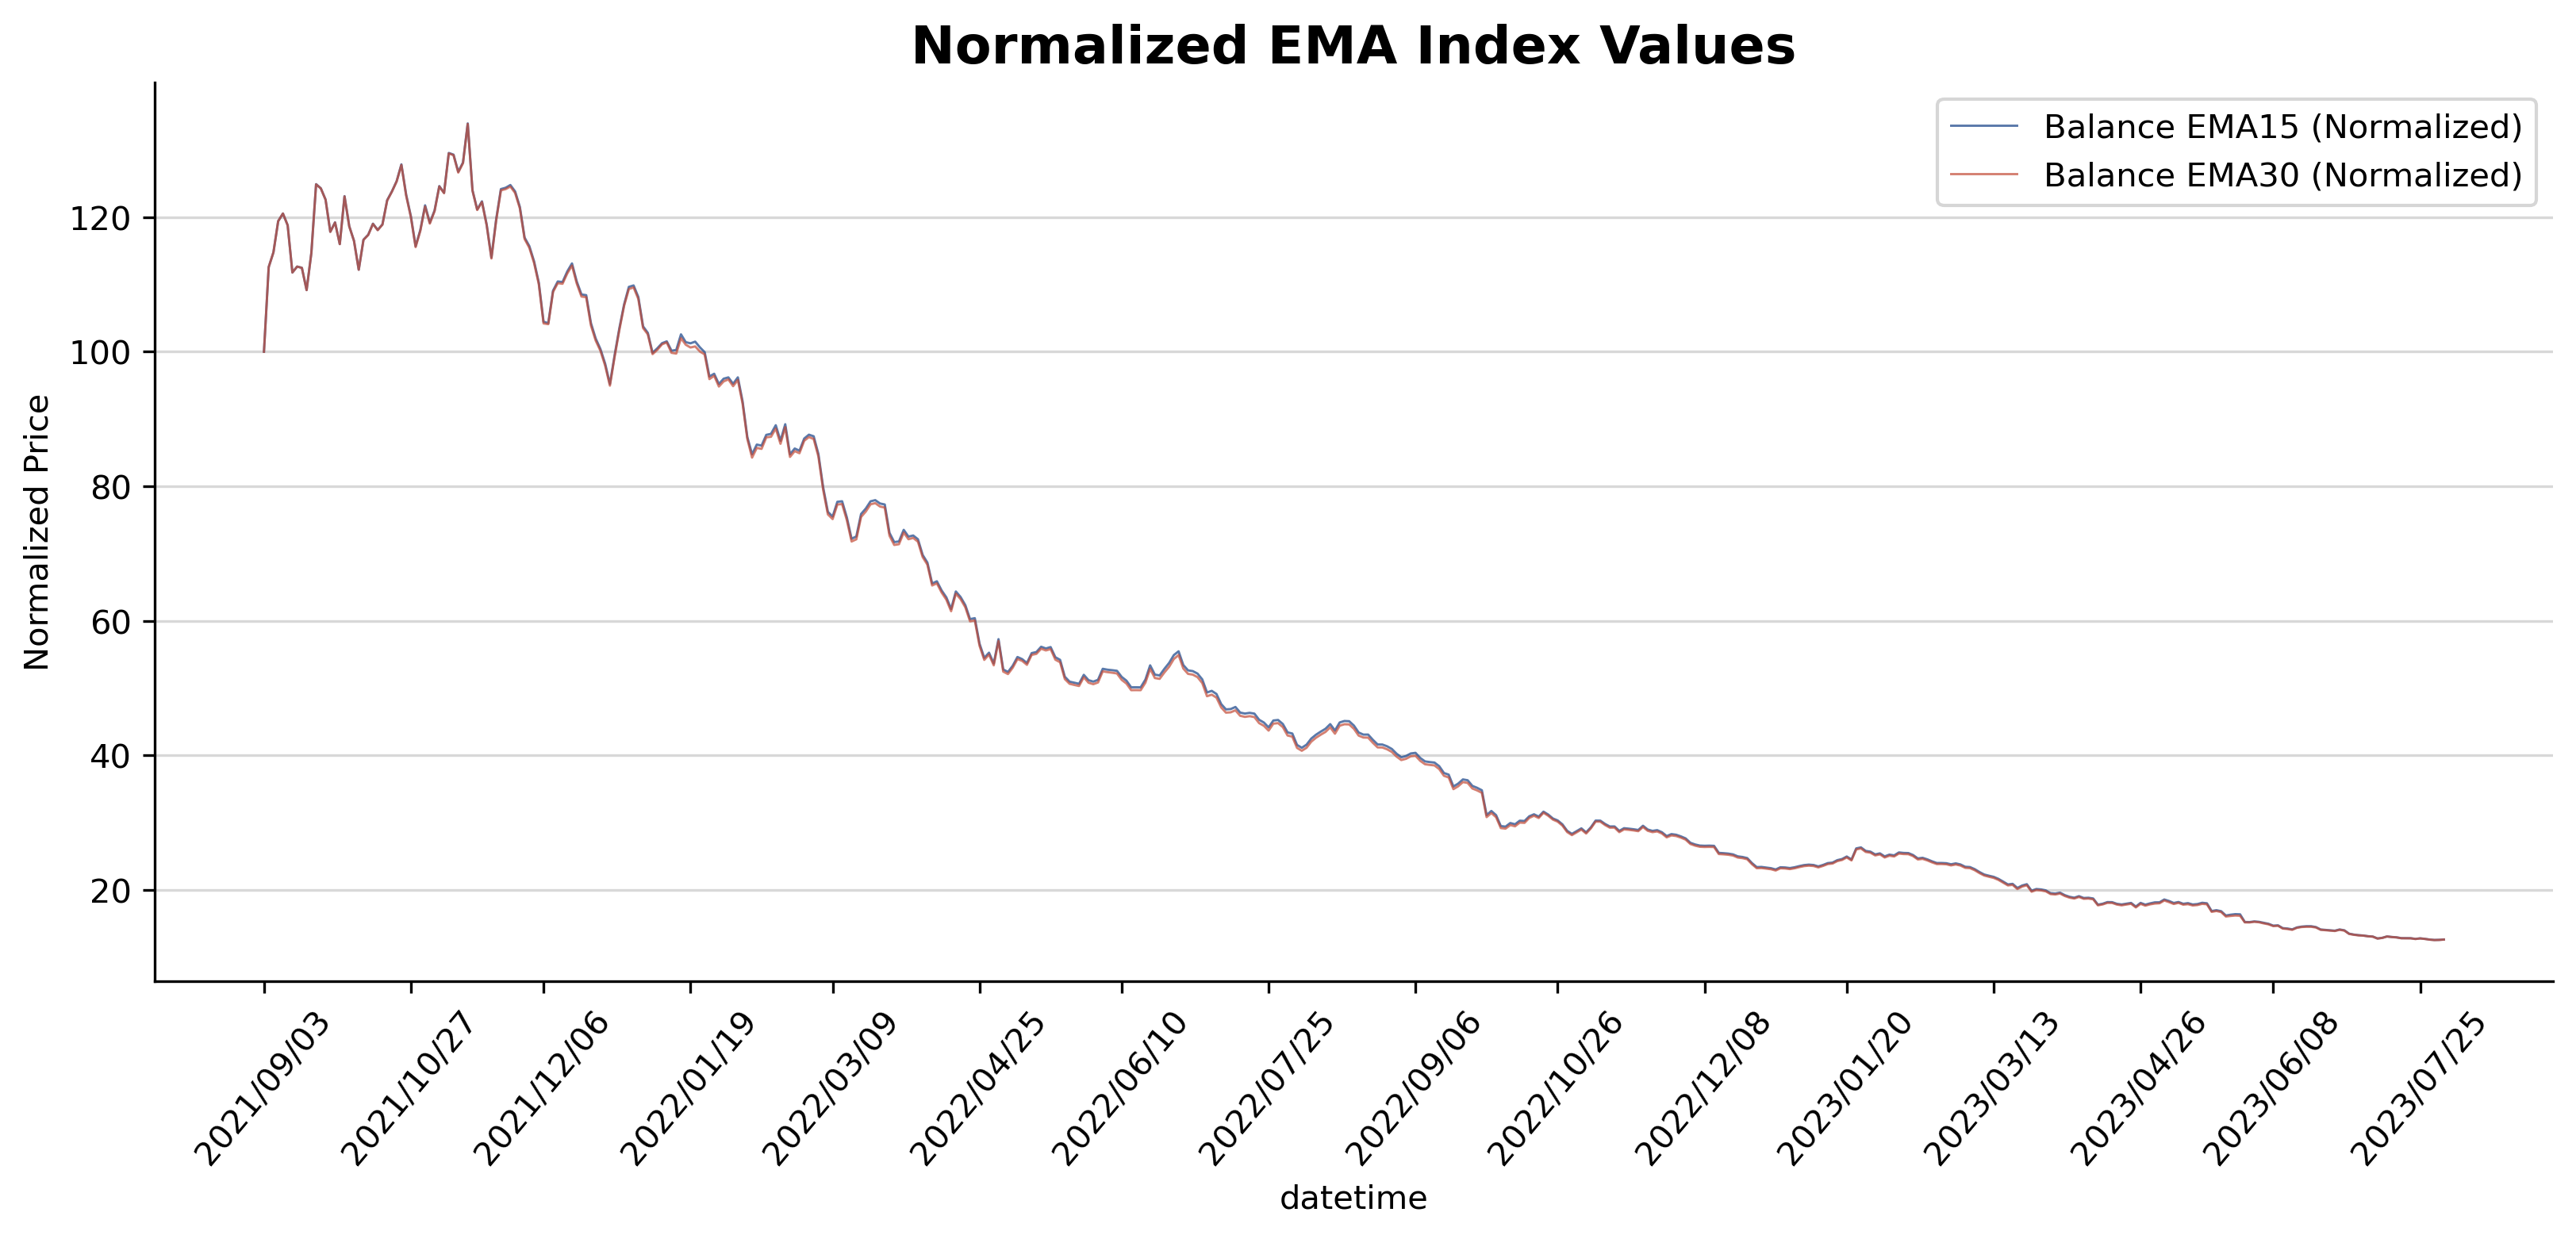

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# import mdates
import matplotlib.dates as mdates

plt.style.use('seaborn-bright')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
background = tuple(np.array([250, 247, 240]) / 255)
blue = tuple(np.array([20, 64, 134]) / 255)
pink = tuple(np.array([193, 148, 168]) / 255)
orange = '#C34A36'
fig, ax = plt.subplots(figsize=(13, 5))

df_bj = df_result_1.copy()

df_bj['Balance_EMA15_normalized'] = df_bj['Balance_EMA15'] 
df_bj['Balance_EMA30_normalized'] = df_bj['Balance_EMA30'] 
volatility_text = ""

# plotting Index_EMA26 and Index_EMA5 log scale
# log
df_bj['Balance_EMA5_log_normalized'] = np.log(df_bj['Balance_EMA15_normalized'])
df_bj['Balance_EMA26_log_normalized'] = np.log(df_bj['Balance_EMA15_normalized'])


ax.plot(df_bj['datetime'], df_bj['Balance_EMA15_normalized'], label='Balance EMA15 (Normalized)', color= blue, lw=0.7,  alpha=0.7)
ax.plot(df_bj['datetime'], df_bj['Balance_EMA30_normalized'], label='Balance EMA30 (Normalized)', color= orange, lw=0.7,  alpha=0.7)

pink = tuple(np.array([220, 80, 148]) / 255)

ax.set_title("Normalized EMA Index Values", fontsize=16, fontweight="bold")
ax.set_ylabel("Normalized Price")
ax.set_xlabel('datetime')
ax.legend(fontsize='medium')
ax.grid(axis='y',color="grey", alpha=0.3)

# Add annualized volatility footnote
#plt.figtext(0.01, 0.01, volatility_text, fontsize=10, color="grey", ha="left", va="bottom")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="x", labelrotation= 50)

# indicate index composition changes
for adjustment_dates in rebalance_dates:
    ax.axvline(x=adjustment_dates, color='grey', linestyle='--', lw=0.5, alpha=0.5)


plt.title("BJSE Index Performance (EMA)", fontsize = 22, fontweight = "bold", y = 1.15)
# put subtitle below title, NOT ABOVE
plt.suptitle("BJSE Index Performance", fontsize = 14, y = 0.95,fontweight = "bold",)

ax.annotate('Exponential Weighted Moving Average Market Cap,' + "\n" + 'Weekly Rebalanced,' + "\n" + "Price Normalized to 100 on Sep 2019" + "\n" ,
    xy=(0.6, 0.6), xycoords='axes fraction',
    # change the font size
    # change the color
    color = blue,
    # change the font
    fontname = "Arial",
    fontsize = 12)


#plt.show()
fig_name = "Index Performance (EMA MCAP Weighted)"
plt.savefig(fig_name + ".png", dpi = 300, bbox_inches = "tight", facecolor = "white")
